In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [3]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Создадим агрегатор

In [4]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import ConfidenceClassifier
from src.aggregate.merge import UnionMerger

In [5]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1

In [6]:
classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
merger = UnionMerger(N_CLASSES)
gt_aggregator = Aggregator(classifier, merger)

### Интерполированный тест

In [7]:
import pickle
import json
TEST_NAME = 'sparse'
with open(f'../../../groups/gt_test_{TEST_NAME}.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'../../../groups/pred_test_{TEST_NAME}.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 21


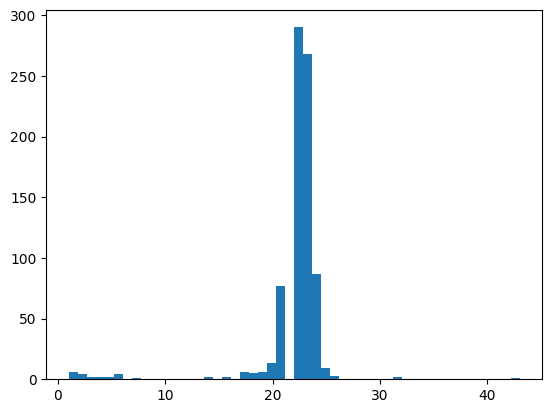

In [8]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [9]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [10]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [11]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

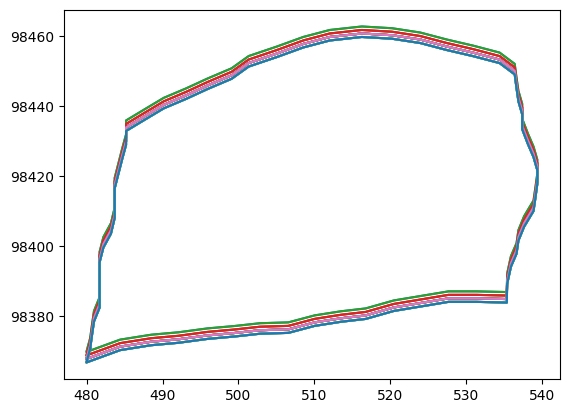

In [12]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Метрики

In [13]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.7):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

### Оптимальный агрегатор

In [ ]:
def find_best_aggregator(gt):
    thresholds = list(range(1, 10))
    confidences = np.linspace(0.35, 0.9, 12)
    remove_border_options = [False, True]
    precisions = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))
    recalls    = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))
    f1_scores  = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))

    for i, remove_borders in enumerate(remove_border_options):
        for j, integration_threshold in enumerate(thresholds):
            for k, confidence_threshold in enumerate(confidences):
                compose_list = []
                if remove_borders:
                    compose_list.append(NoBorderClassifier(N_CLASSES, IMAGE_SHAPE))
                compose_list.append(ThresholdClassifier(N_CLASSES, integration_threshold))
                compose_list.append(ConfidenceClassifier(N_CLASSES, confidence_threshold))
                classifier = ComposeClassifier(compose_list)
                merger = UnionMerger(N_CLASSES)
                aggregator = Aggregator(classifier, merger)
                
                pred = aggregator.aggregate(pred_groups)
                gt_matches, pred_matches = find_matches(gt, pred)

                precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
                recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

                precisions[i, j, k] = precision
                recalls[i, j, k] = recall
                f1_scores[i, j, k] = f1

                print(f"No border: {remove_borders}, Integration: {integration_threshold}, Confidence: {confidence_threshold}. F1: {f1}")

    return precisions, recalls, f1_scores

In [ ]:
gt = gt_aggregator.aggregate(gt_groups)
precisions, recalls, f1_scores = find_best_aggregator(gt)

100%|██████████| 792/792 [00:40<00:00, 19.51it/s]


No border: False, Integration: 1, Confidence: 0.5. F1: 0.8693906483642139


100%|██████████| 792/792 [00:39<00:00, 19.92it/s]


No border: False, Integration: 1, Confidence: 0.55. F1: 0.8770569470326269


100%|██████████| 792/792 [00:37<00:00, 20.86it/s]


No border: False, Integration: 1, Confidence: 0.6. F1: 0.8807249890177831


100%|██████████| 792/792 [00:36<00:00, 21.67it/s]


No border: False, Integration: 1, Confidence: 0.65. F1: 0.8871105229868151


100%|██████████| 792/792 [00:34<00:00, 23.12it/s]


No border: False, Integration: 1, Confidence: 0.7. F1: 0.8765805154539289


100%|██████████| 792/792 [00:33<00:00, 23.65it/s] 


No border: False, Integration: 1, Confidence: 0.75. F1: 0.8683623594172639


100%|██████████| 792/792 [00:29<00:00, 26.47it/s] 


No border: False, Integration: 1, Confidence: 0.8. F1: 0.8369435848607474


100%|██████████| 792/792 [00:25<00:00, 31.43it/s] 


No border: False, Integration: 1, Confidence: 0.8500000000000001. F1: 0.7725182514919269


 24%|██▍       | 194/792 [00:00<00:03, 155.51it/s]

100%|██████████| 792/792 [00:10<00:00, 77.94it/s] 


No border: False, Integration: 1, Confidence: 0.9. F1: 0.39956769160635347


KeyboardInterrupt: 

In [16]:
with open(f"{TEST_NAME}_precision.pkl", 'wb') as f:
    pickle.dump(precisions, f)
with open(f"{TEST_NAME}_recalls.pkl", 'wb') as f:
    pickle.dump(recalls, f)
with open(f"{TEST_NAME}_f1_scores.pkl", 'wb') as f:
    pickle.dump(f1_scores, f)

NameError: name 'precisions' is not defined

### Визуализация группы

In [ ]:
iidx = 0
gidx = 20

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from utils.interpolate.markup_utils import vis_markup

for instance in pred_extended_groups[gidx][iidx:iidx+1]:
    print(instance['is_matched'], instance['is_border'], instance['img'])
    name = Path(instance['img']).name
    s = shifts[name] % 1000
    img = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img = vis_markup(img, [instance['obj']])
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].set_title('Ground truth')
    axs[0].axis('off')
    axs[0].imshow(img)
    axs[0].axhline(y=img.shape[0]-s, color='r', linestyle='-')
    img_gt = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img_gt = vis_markup(img_gt, [shift_mask(obj, -s) for obj in pred_groups[gidx]])
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[1].imshow(img_gt)
    axs[1].axhline(y=img_gt.shape[0]-s, color='r', linestyle='-')
    
    
iidx += 1
print(shifts[name])

plt.show()

False True runs/segment/predict/tula_sep_0002_2024_07_22_18_00_36_200.jpg


[ WARN:0@913.919] global loadsave.cpp:268 findDecoder imread_('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs/tula_sep_0002_2024_07_22_18_00_36_200.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
iidx = 0
gidx += 1

In [ ]:
gt_groups[gidx][0]

{'cls': '0',
 'points': array([[     335.91,      1293.4],
        [     335.91,      1292.2],
        [     330.92,      1287.2],
        [     330.92,      1285.9],
        [     329.66,      1284.7],
        [     312.19,      1284.7],
        [     310.94,      1285.9],
        [     309.69,      1285.9],
        [     308.44,      1287.2],
        [     307.19,      1287.2],
        [     305.94,      1288.4],
        [      304.7,      1288.4],
        [     303.45,      1289.7],
        [     300.95,      1289.7],
        [      299.7,      1290.9],
        [     295.95,      1290.9],
        [     292.22,      1294.7],
        [     292.22,      1300.9],
        [     292.29,        1301],
        [     343.48,        1301],
        [     335.91,      1293.4]], dtype=float32),
 'count': 1}

In [ ]:
shifts

{'tula_sep_0002_2024_07_16_14_17_15_000.jpg': 60,
 'tula_sep_0002_2024_07_16_14_17_15_200.jpg': 120,
 'tula_sep_0002_2024_07_16_14_17_15_400.jpg': 180,
 'tula_sep_0002_2024_07_16_14_17_15_600.jpg': 240,
 'tula_sep_0002_2024_07_16_14_17_15_800.jpg': 301,
 'tula_sep_0002_2024_07_16_14_17_16_000.jpg': 362,
 'tula_sep_0002_2024_07_16_14_17_16_200.jpg': 422,
 'tula_sep_0002_2024_07_16_14_17_16_400.jpg': 483,
 'tula_sep_0002_2024_07_16_14_17_16_600.jpg': 545,
 'tula_sep_0002_2024_07_16_14_17_16_800.jpg': 606,
 'tula_sep_0002_2024_07_16_14_17_17_000.jpg': 668,
 'tula_sep_0002_2024_07_16_14_17_17_200.jpg': 729,
 'tula_sep_0002_2024_07_16_14_17_17_400.jpg': 789,
 'tula_sep_0002_2024_07_16_14_17_17_600.jpg': 851,
 'tula_sep_0002_2024_07_16_14_17_17_800.jpg': 912,
 'tula_sep_0002_2024_07_16_14_17_18_000.jpg': 974,
 'tula_sep_0002_2024_07_16_14_17_18_200.jpg': 1036,
 'tula_sep_0002_2024_07_16_14_17_18_400.jpg': 1097,
 'tula_sep_0002_2024_07_16_14_17_18_600.jpg': 1159,
 'tula_sep_0002_2024_07_16_14

In [ ]:
shifts['tula_sep_0002_2024_07_16_14_17_15_600.jpg']

240